loss= distance(style(reference_image)-style(generated_image))+
      distance(content(orginal_image)-content(generated_image))

In [12]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()


from keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array
import numpy as np
from numpy import uint8
from keras.applications import vgg19
from keras import backend as K

from scipy.optimize import fmin_l_bfgs_b
from keras.preprocessing.image import save_img
import time

from matplotlib import pyplot as plt

In [13]:
#path of image we want to transform
target_image_path =r"C:/Users/sriya/OneDrive/Desktop/style/Style/input/image-classification/validation/validation/travel and adventure/6.jpg"

#path of style image
style_reference_image_path=r"C:/Users/sriya/OneDrive/Desktop/style/Style/input/Best Artworks of All Time/resized/resized/William_Turner_9.jpg"


#dimensions of the generated image
width, height= load_img(target_image_path).size
img_height=400
img_width=int(width*img_height/height)


In [14]:
def preprocess_image(image_path):
    img=load_img(image_path,target_size=(img_height,img_width))
    img=img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=vgg19.preprocess_input(img)
    return img


def deprocess_img(x):
    #remove zero-center by mean pixel
    x[:,:,0]+=103.939    
    x[:,:,1]+=116.779   
    x[:,:,2]+=123.68
    
    #'BGR' ->'RGB'
    
    x=x[:,:,::-1]
    x=np.clip(x,0,225).astype(uint8)
    return x
    

In [15]:
target_image= K.constant(preprocess_image(target_image_path))
style_reference_image= K.constant(preprocess_image(style_reference_image_path))

#base_image = K.variable(preprocess_image_instantiator(base_image_path,img_nrows,img_ncols))
#style_reference_image = K.variable(preprocess_image_instantiator(style_image_path,img_nrows,img_ncols))
    

#this placeholder will contain our generated image
combination_image=K.placeholder((1,img_height,img_width,3))

#combine 3 images a single batch
input_tensor=K.concatenate([target_image,
                            style_reference_image,
                            combination_image],axis=0)

#we build the vgg19 network with our batch of 3 images as input
#the model will be loaded with pre-trained ImageNet weights
model=vgg19.VGG19(input_tensor=input_tensor,
                  weights='imagenet',
                  include_top=False)
print('Model Loaded.')

Model Loaded.


In [16]:
def content_loss(base,combination):
    return K.sum(K.square(combination-base))

In [17]:
def gram_matrix(x):
    features=K.batch_flatten(K.permute_dimensions(x,(2,0,1)))
    gram=K.dot(features,K.transpose(features))
    return gram

def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=img_height*img_width
    return K.sum(K.square(S-C))/(4.*(channels**2)*(size**2))


In [18]:
def total_variation_loss(x):
    a=K.square(
        x[:,:img_height-1,:img_width-1,:]-x[:,1:,:img_width-1,:]
    )
    b=K.square(
        x[:,:img_height-1,:img_width-1,:]-x[:,:img_height-1,1:,:]
    )
    return K.sum(K.pow(a+b,1.25))
    
    

In [19]:
#dict mapping layer names to activation tensors
outputs_dict= dict([(layer.name,layer.output) for layer in model.layers])
#name of layer used for content loss
content_layer='block5_conv2'
#name of layers used for style loss
style_layers=[
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

#weights in the weighted average of the loss components
total_variation_weight=1e-4
style_weight=1.
content_weight=0.025

#define the loss by adding all components to a 'loss' variable
loss=K.variable(0.)
layer_features=outputs_dict[content_layer]
target_image_features=layer_features[0,:,:,:]
combination_features=layer_features[2,:,:,:]
loss= loss+content_weight*content_loss(target_image_features,
                                       combination_features)

for layer_name in style_layers:
    layer_features=outputs_dict[layer_name]
    style_reference_features=layer_features[1,:,:,:]
    combination_features= layer_features[2,:,:,:]
    sl=style_loss(style_reference_features,combination_features)
    loss+= (style_weight/len(style_layers))*sl
    
loss+=total_variation_weight*total_variation_loss(combination_image)    

In [20]:
#get the gradients of the generated image wrt the loss
grads=K.gradients(loss,combination_image)[0]

#function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads= K.function([combination_image],[loss,grads])



class Evaluator(object):
    
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
        
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grads_values = grad_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grads_values)  # Use the correct attribute name here
        self.loss_value = None
        self.grads_values = None  # Use the correct attribute name here
        return grad_values



In [21]:
evaluator = Evaluator() 

In [22]:
result_prefix= 'style_transfer_result'
iterations=5


#run scipy-based optimization(L-BFGS) over the pixels of the generated image
#so as to minimize the neural style loss
#this is our inital state :the target image
#note that 'scipy.optimize.fmin_l_bfgs_b' can only process flat vectors

x=preprocess_image(target_image_path)
x=x.flatten()
for i in range(iterations):
    print('Start of iteration ',i)
    start_time=time.time()
    x,min_val,info =fmin_l_bfgs_b(evaluator.loss, x, 
                                        fprime=evaluator.grads,
                                        maxfun=20,
                                        disp=True)
    print('Current loss value: ', min_val)
    #save current generated image 
    img = x.copy().reshape((img_height,img_width,3))
    img= deprocess_img(img)
    fname=result_prefix+'_at_iteration_%d.png' %i
    save_img(fname,img)
    end_time = time.time()
    print('Image saved as ', fname)
    print('Iteration %d completed in %ds ' %(i,end_time-start_time))
    

Start of iteration  0
Current loss value:  724719170.0
Image saved as  style_transfer_result_at_iteration_0.png
Iteration 0 completed in 327s 
Start of iteration  1
Current loss value:  261400800.0
Image saved as  style_transfer_result_at_iteration_1.png
Iteration 1 completed in 318s 
Start of iteration  2
Current loss value:  180531870.0
Image saved as  style_transfer_result_at_iteration_2.png
Iteration 2 completed in 305s 
Start of iteration  3
Current loss value:  144182510.0
Image saved as  style_transfer_result_at_iteration_3.png
Iteration 3 completed in 323s 
Start of iteration  4
Current loss value:  125272280.0
Image saved as  style_transfer_result_at_iteration_4.png
Iteration 4 completed in 330s 


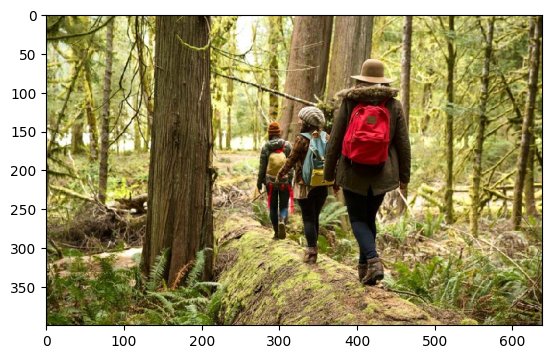

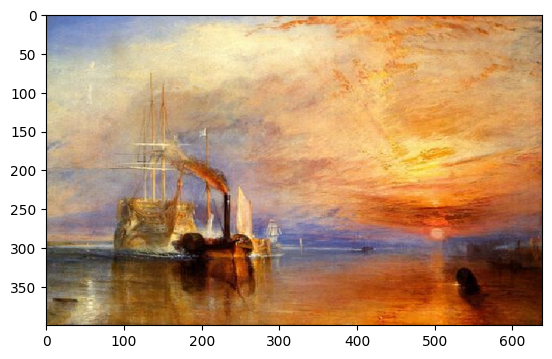

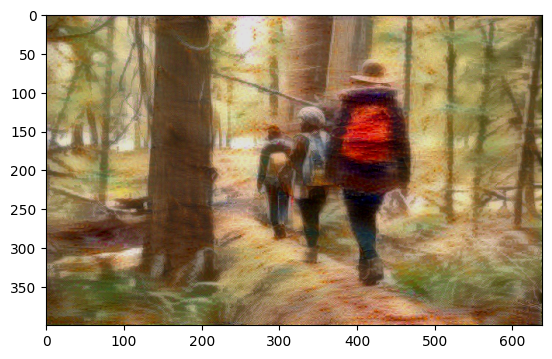

In [23]:
#content image
plt.imshow(load_img(target_image_path,target_size=(img_height,img_width)))
plt.figure()

#style image
plt.imshow(load_img(style_reference_image_path,target_size=(img_height,img_width)))
plt.figure()

#generate image 
plt.imshow(img)
plt.show() 